# Recommendation Systems
## Assignment 1: Matrix Factorization & Evaluation

**By:**  
Group 99

<br><br>

**The goal of this assignment is to:**
- Understand the details of matrix factorization algorithm
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- Please use English language only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a Jupyter notbook.
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used.  
- You should implement the matrix factorization algorithm by yourself using only basic Python libraries (such as numpy).



<br><br><br><br>

**Grading:**
- Q1 - 0 points - Data exploration
- Q2 - 25 points - Evaluation metrics
- Q3 - 50 points - Models implementation and evaluation
  -  A. Popularity basline model: 10 points
  -  B. Explicit Matrix Factorization: 25 points
  -  C. Train & HyperParams Search: 5 points 
  -  D. Bias only model: 5 points
  -  E. Discussion: 5 points
- Q4 - 25 points - Similarity & Explainability 

`Total: 100`

**Prerequisites**

In [170]:
# !pip install --quiet zipfile36 pandas seaborn
%pip install --quiet zipfile36 pandas seaborn


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


In [171]:
# general
import time
import random
import zipfile
import requests
import warnings

# ml
import numpy as np
import scipy as sp
import pandas as pd

# visual
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

# metrics - do not use these metrics, but you can use them to check your work
from sklearn.metrics import mean_squared_error,ndcg_score 

# notebook
from IPython.display import FileLink, display

**Hide Warnings**

In [172]:
warnings.filterwarnings('ignore')

**Disable Autoscrolling**

In [173]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

**Set Random Seed**

In [174]:
random.seed(123)

# Question 1:

## Data exploration 

Download the MovieLens 100K rating dataset.   
Calculate the dataset sparsity, distribution of number of ratings as well as the average rating value per user\item.  
Include additional exploration you find relevant to questions 2 and 3.  
Discuss your insights and possible challenges related to the prediction task described in question 2.  

In [175]:
url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
zip_name = 'ml-100k.zip'
data_dir = 'ml-100k/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

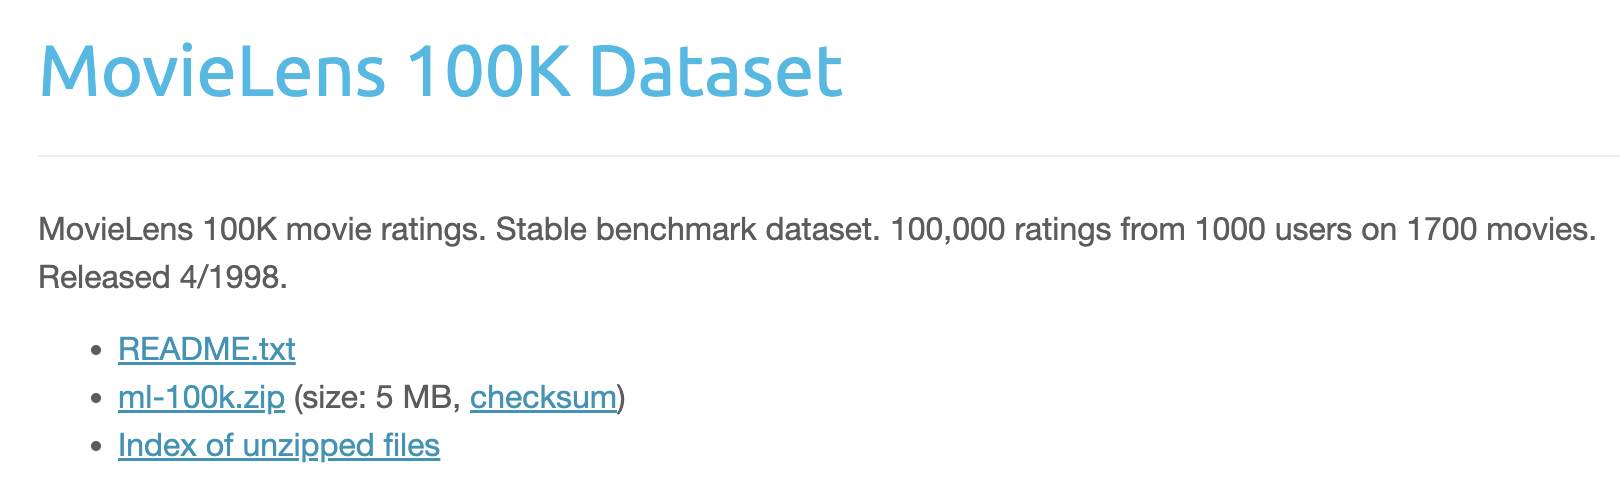

**Columns Names**

In [176]:
cols_data = ['user_id','item_id','rating','timestamp']
cols_user = ['user_id','age','gender','occupation','zip code']
cols_item = ['movie id','movie_title','release_date','video_release_date','IMDb_URL','unknown','Action','Adventure','Animation',
             'Childrens','Comedy','Crime','Documentary','Drama','Fantasy','Film_Noir','Horror','Musical','Mystery','Romance',
             'Sci_Fi','Thriller','War','Western']

**Read users data file**

In [177]:
df_users = pd.read_csv(data_dir + 'u.user',delimiter='|', header=None,names=cols_user)
df_users.shape

(943, 5)

**Read items(movies) data file**

In [178]:
df_items = pd.read_csv(data_dir + 'u.item',delimiter='|', header=None,names=cols_item,encoding="ISO-8859-1")
df_items.shape

(1682, 24)

**Read rating data file**

In [179]:
df_ratings = pd.read_csv(data_dir + 'u.data',delimiter='\t', header=None,names=cols_data)
df_ratings.shape

(100000, 4)

Making sure shapes are matching the info data file

In [180]:
open(data_dir + 'u.info').readlines()

['943 users\n', '1682 items\n', '100000 ratings\n']

**Matrix:**

In [181]:
ratings = df_ratings.pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<br><br><br><br>
**Explore ratings data:**

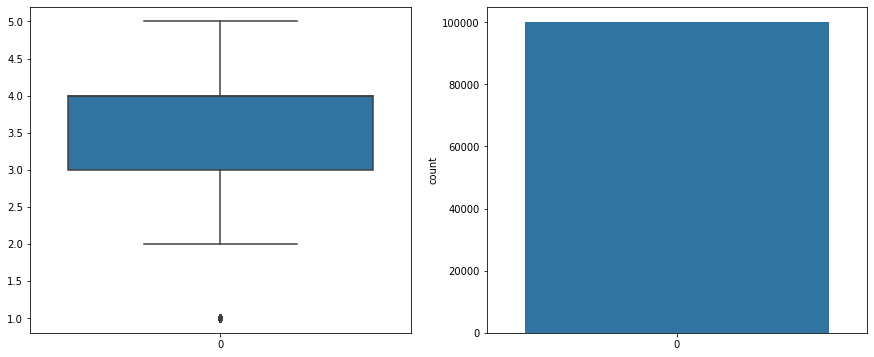

In [182]:
f, axes = plt.subplots(1, 2,figsize=(15,6))
sns.boxplot(df_ratings.rating,ax=axes[0])
sns.countplot(df_ratings.rating,ax=axes[1])
plt.show()

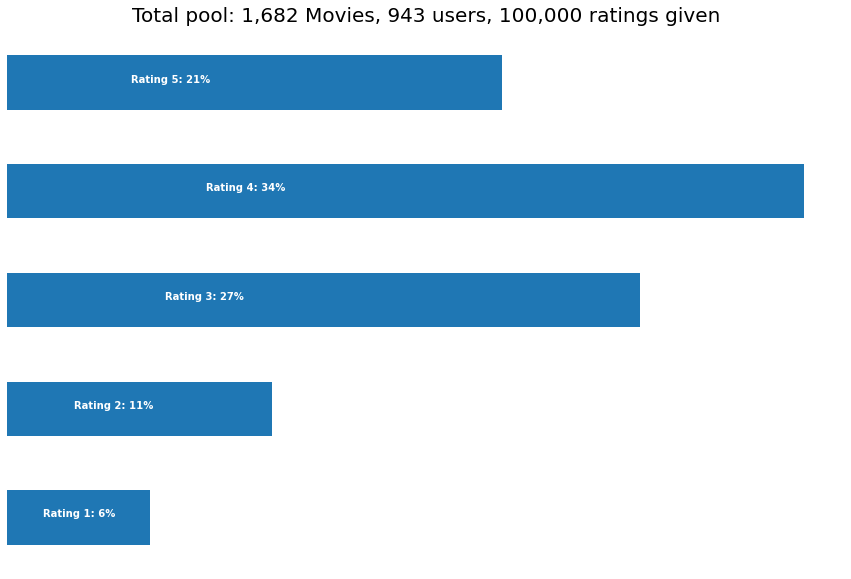

In [183]:
p = df_ratings.groupby('rating')['rating'].agg(['count'])
movie_count = df_ratings.item_id.nunique()
cust_count = df_ratings.user_id.nunique() 
rating_count = df_ratings.user_id.count()

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} users, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

**Distribution of number of ratings per user\item**

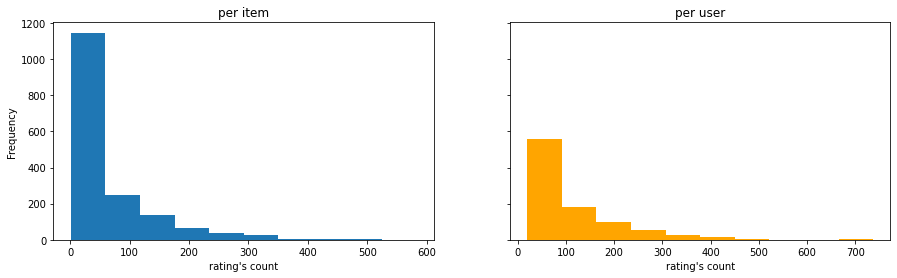

In [184]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.astype(bool).sum(axis=0).plot.hist(ax=ax[0])
ratings.astype(bool).sum(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('rating\'s count')
ax[1].set_xlabel('rating\'s count');

**Distribution of average rating value  per user\item**

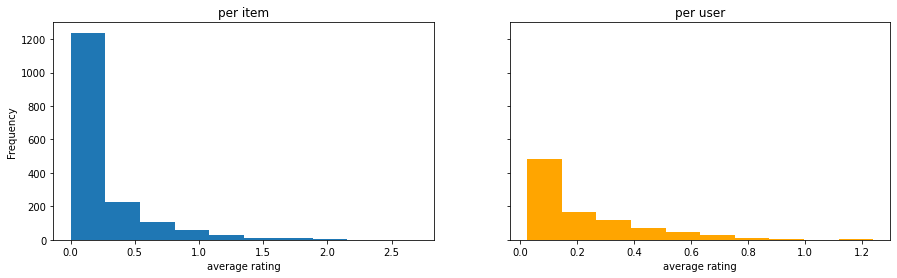

In [185]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 4))

ratings.mean(axis=0).plot.hist(ax=ax[0])
ratings.mean(axis=1).plot.hist(ax=ax[1],color='orange')
ax[0].set_title('per item')
ax[1].set_title('per user')
ax[0].set_xlabel('average rating')
ax[1].set_xlabel('average rating');

**Movie ratings aggregated by user**

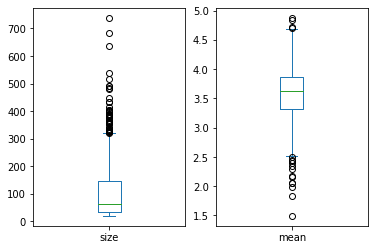

In [186]:
userRatingsAggr = df_ratings.groupby(['user_id']).agg({'rating': [np.size, np.mean]})
userRatingsAggr.reset_index(inplace=True)  # To reset multilevel (pivot-like) index
userRatingsAggr['rating'].plot(kind='box', subplots=True)
plt.show();

**Genres**

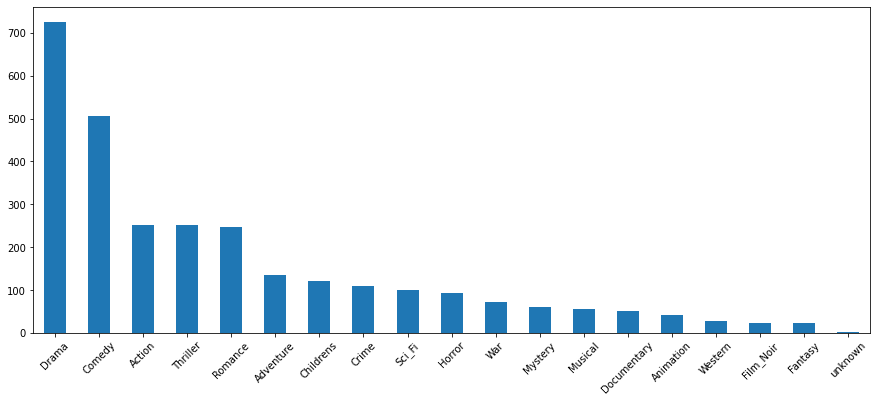

In [187]:
plt.figure(figsize=(15,6))
df_items.iloc[:,5:].sum().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=45)
plt.show();

**Calculate the dataset sparsity:**

$$
Density  = \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}} 
\quad \qquad
Sparsity = 1 - \frac{\text{number of nonzero ratings in the matrix}}{\text{number of users}\times\text{number of items}}
$$

In [188]:
matrix_sparsity =  round((1-np.count_nonzero(ratings)/ratings.size)*100,2)
print('Sparsity is equal to {}%'.format(str(matrix_sparsity)) )

Sparsity is equal to 93.7%


<br><br><br><br><br><br>

# Question 2:


## Evaluation Metrics

Please create a class to calculate the following metrics on two different dataset (df_true,df_pred):
- RMSE
- MRR
- nDCG

**Notes:**
- Please read this great blog post: 
<a href='https://medium.com/swlh/rank-aware-recsys-evaluation-metrics-5191bba16832'>MRR vs MAP vs NDCG: Rank-Aware Evaluation Metrics And When To Use Them </a>
- Please consider edge cases - NaN, Null, Zeros, out of bound, eval time, etc.
- You can work with Dataframe or with Numpy arrays(matrix)
- You may remove/add params to these functions
- Please use only pytonic code!

In [189]:
class my_metrics:
    @staticmethod
    def RMSE(df_true: np.ndarray, df_pred: np.ndarray, lower_bound=1, upper_bound=5) -> float:
        """ Root Mean Squared Error for all users """
        number_of_users = df_true.shape[0]
        # Convert to numpy array
        errors_for_users = [my_metrics.RMSE_for_user(df_true[i], df_pred[i], lower_bound, upper_bound ) for i in range(number_of_users)]
        return np.mean(errors_for_users)

    @staticmethod
    def RMSE_for_user(user_true: np.ndarray, user_pred: np.ndarray, lower_bound=1, upper_bound=5) -> float:
        """ RMSE for a single user

        Args:
            user_true (np.ndarray): true ratings
            user_pred (np.ndarray): predicted ratings
            lower_bound (int): lower bound for ratings
            upper_bound (int): upper bound for ratings

        Returns:
            float: RMSE for a single user
        """
    
        return np.sqrt(np.mean((user_true - user_pred) ** 2))

    @staticmethod
    def MRR(df_true: np.ndarray, df_pred: np.ndarray, lower_bound=4, top_n=5) -> float:
        """ Mean Reciprocal Rank for all users """
        num_of_users = df_true.shape[0]
        scores = [
            my_metrics.MRR_for_user(df_true[i], df_pred[i], lower_bound, top_n)
            for i in range(num_of_users)
        ]
        return np.mean(scores)

    @staticmethod
    def MRR_for_user(user_true: np.ndarray, user_pred: np.ndarray, lower_bound=4, top_n=5) -> float:
        """ Computes MRR for a single user.
        Args:
            user_true: list of true ratings for a single user
            user_pred: list of predicted ratings for a single user
            lower_bound: lower bound of rating scale
            top_n: number of top items to consider
        Returns:
            MRR for a single user
        """

        # Get the indices of the top_n items in user pred ratings
        top_n_indices = np.argsort(user_pred)[::-1][:top_n]
        for key, value in enumerate(top_n_indices):
            if user_pred[value] >= lower_bound and user_true[value] >= lower_bound:
                return 1 / (key + 1)
        # if there is no match, return 0
        return 0

    @staticmethod
    def NDCG(df_true: np.ndarray, df_pred: np.ndarray, top_n=5) -> float:
        """ Computes NDCG for all users """
        num_of_users = df_true.shape[0]
        scores = [
            my_metrics.NDCG_for_user(df_true[i], df_pred[i], top_n)
            for i in range(num_of_users)
        ]
        return np.mean(scores)

    @staticmethod
    def NDCG_for_user(user_true: np.ndarray, user_pred: np.ndarray, top_n=5) -> float:
        """ Computes NDCG for a single user.
        Args:
            user_true: list of true ratings for a single user
            user_pred: list of predicted ratings for a single user
            lower_bound: lower bound of rating scale
            upper_bound: upper bound of rating scale
            top_n: number of top items to consider
        Returns:
            NDCG for a single user
        """
        # Get the indices of the top_n items in user pred ratings
        top_n_indices = np.argsort(user_pred)[::-1][:top_n]
        dcg = 0
        for key, value in enumerate(top_n_indices):
            dcg += user_true[value] / np.log2(key + 2)

        idcg = 0
        top_n_true_indices = np.argsort(user_true)[::-1][:top_n]
        for key, value in enumerate(top_n_true_indices):
                idcg += user_true[value] / np.log2(key + 2)
        
        return dcg / idcg if idcg != 0 else 0

    @staticmethod
    def DCG(rel, n):
        # please implement the DCG formula
        pass

    @staticmethod
    def get_error(df_true: np.ndarray, df_pred: np.ndarray) -> dict:
        return {
            "RMSE": my_metrics.RMSE(
                df_true,
                df_pred,
            ),
            "MRR_5": my_metrics.MRR(df_true, df_pred, top_n=5),
            "MRR_10": my_metrics.MRR(df_true, df_pred, top_n=10),
            "NDCG_5": my_metrics.NDCG(df_true, df_pred, top_n=5),
            "NDCG_10": my_metrics.NDCG(df_true, df_pred, top_n=10),
        }


Checking your evaltuation metrics and performence:

In [190]:
# Convert to numpy array
ratings_as_array = ratings.to_numpy(copy=True)
%time my_metrics.get_error(ratings_as_array,ratings_as_array)

CPU times: total: 234 ms
Wall time: 225 ms


{'RMSE': 0.0,
 'MRR_5': 0.9989395546129375,
 'MRR_10': 0.9989395546129375,
 'NDCG_5': 1.0,
 'NDCG_10': 1.0}

<br><br><br><br>

# Question 3

### Models Implementation & Evaluation
Split the data to train and test.  
Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.   

Use the RMSE, MRR and NDCG metrics (based on Q2 implementation) to evaluate your recommender system. For the MRR and NDCG metrics use cutoff value of 5. Items with a rating of 3 and above are considered as relevant.   

Produce a learning curve graph and a table which compares the results of the following algorithms: 
 - Bias only based model
 - Simple popularity based model
 - Different choices of the latent factor dimension regularization, learning rate. 



**Save final results**

In [191]:
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])

**Choose fold**

In [192]:
df_folds = {i:
       {'train' : pd.read_csv('{}u{}.base'.format(data_dir,i), delimiter='\t', header=None, names=cols_data),
        'test'  : pd.read_csv('{}u{}.test'.format(data_dir,i), delimiter='\t', header=None, names=cols_data)
       } for i in range(1,6)} 

def fold2df(i):
    train = df_folds[i]['train'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    test  = df_folds[i]['test'].pivot(index = 'user_id', columns ='item_id', values = 'rating').fillna(0)
    return train,test 

def getfulldf(train_fold,test_fold):
    train = ratings.copy()
    train[:] = 0
    test = train.copy()
    
    train.loc[train_fold.index,train_fold.columns] = train_fold.values
    test.loc[test_fold.index,test_fold.columns] = test_fold.values
    return train,test

fold = 1
train,test = getfulldf(*fold2df(fold))

train.shape,test.shape

((943, 1682), (943, 1682))

### A. Popularity model

Recommend the most popular movies which have more than 10 ratings.

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [193]:
class POP():

    def __init__(self,df_train,M=10):
    # df is the set to train on
    # N is the number of movies to recommend
    # M is the minimum votes required to be listed in the chart
        self.df_train = (
            df_train if isinstance(df_train, np.ndarray) else df_train.to_numpy(copy=True)
        )
        self.min_movie_ratings = M
        self.recommended = None
        self.fit_time = 0
        self.prediction = None 

        
    def fit(self):
        self.fit_time = 0
        # start timer
        start = time.time()
        # movieCount, movieSum = None, None
        movieCount = np.count_nonzero(self.df_train, axis=0)
        movieSum = np.sum(self.df_train, axis=0)
        movieMean = np.ones_like(self.df_train[0])
        rec = np.divide(movieSum,movieCount,where= (movieCount > self.min_movie_ratings))
        self.recommended= np.resize(rec, new_shape= self.df_train.shape)
        # stop timer
        self.fit_time = time.time() - start
        
        
    def predict(self,N=10):
        # return the top N movies
        self.prediction= None
        self.prediction= np.flip(np.argsort(self.recommended[0])[-(1 + N):-1] )
        return self.prediction

    def get_rmse(self, test):
        return my_metrics.RMSE(test, self.recommended)

    def get_mrr(self, test, k=5, threshold=4):
        return my_metrics.MRR(test, self.recommended, top_n=k, lower_bound=threshold)

    def get_ndcg(self, test, k=10):
        return my_metrics.NDCG(test, self.recommended, top_n=k)

    # this is just a quick checking function for you to use while debugging
    def predict_title(self):
        return df_items.set_index('movie id').loc[self.predict()-1]['movie_title']

Checking your model and performance:

In [194]:
model_pop= None
model_pop = POP(train)

# train model
%timeit model_pop.fit()
print(model_pop.predict_title())

7.41 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
movie id
1122                       They Made Me a Criminal (1939)
113     Horseman on the Roof, The (Hussard sur le toit...
1267                                      Clockers (1995)
1165                                     Big Bully (1996)
1373                                  Good Morning (1971)
1191                      Letter From Death Row, A (1998)
1264                               Nothing to Lose (1994)
851           Two or Three Things I Know About Her (1966)
1066                                         Balto (1995)
1190                              That Old Feeling (1997)
Name: movie_title, dtype: object


In [195]:
# create popularity model
model_pop= None
model_pop = POP(train)

# train model
%timeit model_pop.fit()
print(model_pop.predict_title())
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])
final_results.loc[len(final_results)] = 'Popularity', model_pop.fit_time, model_pop.get_rmse(test.values), model_pop.get_mrr(test.values,k=5), model_pop.get_mrr(test.values,k=10), model_pop.get_ndcg(test.values,k=5), model_pop.get_ndcg(test.values,k=10)

# display
final_results

7.37 ms ± 89.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
movie id
167           Private Benjamin (1980)
316         As Good As It Gets (1997)
481             Apartment, The (1960)
62                    Stargate (1994)
10                 Richard III (1995)
48                 Hoop Dreams (1994)
601    For Whom the Bell Tolls (1943)
112                    Flipper (1996)
511         Lawrence of Arabia (1962)
176                     Aliens (1986)
Name: movie_title, dtype: object


,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,Popularity,0.008003,2.629748,0.053694,0.066569,0.03413,0.038721


### B. Explicit Matrix Factorization

**Implement explicit matrix factorization algorithm to predict the rating a user will provide to an item and recommendation of top N items.**

Use the RMSE, MRR and NDCG metrics to evaluate your recommender system.   
For the MRR and NDCG metrics use cutoff values of 5 and 10.   

In [196]:
class MF:
    def __init__(self, df_train, n_factors=10, only_bias=False, batch_size=256):
        # convert to numpy array if not already
        self.df_train = (
            df_train if isinstance(df_train, np.ndarray) else df_train.to_numpy(copy=True)
        )
        self.batch_size = batch_size
        self.n_factors = n_factors
        self.only_bias = only_bias
        self.user_vectors = None
        self.item_vectors = None
        self.prediction = None
        self.gradient_user_vectors = None
        self.gradient_item_vectors = None
        # rows==users , cols==items
        self.n_rows, self.n_cols = df_train.shape

        # biases
        self.original_bias_global = np.sum(df_train) / np.count_nonzero(df_train)
        self.original_bias_rows = np.sum(df_train, axis=1) / np.count_nonzero(df_train, axis=1)
        self.original_bias_cols = np.sum(df_train, axis=0) / np.count_nonzero(df_train, axis=0)

        # "reset" initialization
        self.initialize_params()

    def initialize_params(self):
        if self.only_bias:
            pass
        else:
            self.user_vectors = np.random.normal(
                scale=1.0 / self.n_factors, size=(self.n_rows, self.n_factors)
            )
            self.item_vectors = np.random.normal(
                scale=1.0 / self.n_factors, size=(self.n_cols, self.n_factors)
            )

        # initialize bias
        self.bias_global = self.original_bias_global  # no need to learn it
        self.bias_rows = np.zeros(self.n_rows)
        self.bias_cols = np.zeros(self.n_cols)

    def fit(
        self,
        n_iterations=1,
        learning_rate=1e-1,
        regularization=1e-2,
        convergence=1e-5,
        error="RMSE",
        initialize_training=True,
        verbose=True,
        batch_size=256,
    ):

        self.n_iterations = n_iterations
        self.α = learning_rate
        self.λ = regularization
        self.ϵ = convergence
        self.error = error
        self.sample_row, self.sample_col = self.df_train.nonzero()
        self.n_samples = len(self.sample_row)

        if initialize_training:
            self.initialize_params()

        # please record your progress in history
        self.history = []

        # please record the training time in fit_time
        self.fit_time = 0
        # start timer
        start = time.time()

        # please use the class functions
        # for example(!) :
        for current_iteration in range(self.n_iterations):
            self.prediction = self.predict()
            self.history.append(self.calculate_error())

            # printing
            if verbose:
                print("iteration: ", current_iteration, " total error:\n", self.history[-1])

            # convergence
            if current_iteration != 0 and self.converging():

                if verbose:
                    print("converged...")
                break
            
            # split data
            self.optim_GD()
        
        # stop timer
        self.fit_time = time.time() - start

    def calculate_error(self):
        if self.error == "RMSE":
            return self.get_rmse(self.df_train)
        elif self.error == "MRR":
            return self.get_mrr(self.df_train)
        elif self.error == "NDCG":
            return self.get_ndcg(self.df_train)
        else:
            raise ValueError("error type not supported")

    def converging(self):
        return np.abs(self.history[-1] - self.history[-2]) < self.ϵ

    def optim_GD(self):

        training_indices = np.arange(self.n_samples)
        np.random.shuffle(training_indices)

        for i in training_indices:
            user_index = self.sample_row[i]
            item_index = self.sample_col[i]
            prediction = self.predict_item(user_index, item_index)
            e = (self.df_train[user_index,item_index] - prediction)
            
            self.bias_rows[user_index] += self.α * \
                                (e - self.λ * self.bias_rows[user_index])
            self.bias_cols[item_index] += self.α * \
                                (e - self.λ * self.bias_cols[item_index])
            
            self.user_vectors[user_index, :] += self.α * \
                                    (e * self.item_vectors[item_index, :] - \
                                     self.λ * self.user_vectors[user_index,:])
            self.item_vectors[item_index, :] += self.α * \
                                    (e * self.user_vectors[user_index, :] - \
                                     self.λ * self.item_vectors[item_index,:])

    def predict_item(self, user_index, item_index):
        return self.bias_global + self.bias_rows[user_index] + self.bias_cols[item_index] + self.user_vectors[user_index, :].dot(self.item_vectors[item_index, :].T)

    def predict(self):
        if self.only_bias == False:
            predictions = self.user_vectors @ self.item_vectors.T
        else:
            predictions = np.zeros(self.df_train.shape)

        # Add biases
        predictions += self.bias_global
        predictions += self.bias_rows[:, np.newaxis]
        predictions += self.bias_cols[np.newaxis, :]

        return predictions
        
    def get_rmse(self, test):
        return my_metrics.RMSE(test, self.prediction)

    def get_mrr(self, test, k=5, threshold=4):
        return my_metrics.MRR(test, self.prediction, top_n=k, lower_bound=threshold)

    def get_ndcg(self, test, k=10):
        return my_metrics.NDCG(test, self.prediction, top_n=k)
        # this is just a quick checking function for you to use while debugging

model_mf = MF(train.values,n_factors=5,only_bias=False)
%time model_mf.fit(n_iterations=10,verbose=False,regularization=0.01,convergence=1e-100,learning_rate=0.1)


CPU times: total: 19.5 s
Wall time: 17.7 s


Checking your model and performance:

In [197]:
# create MF model
model_mf = MF(train.values,n_factors=5,only_bias=False)

# train model
%time model_mf.fit(n_iterations=100,verbose=True,regularization=0.01,convergence=0.000001,learning_rate=0.001, initialize_training=True)

# record model results
final_results = pd.DataFrame(columns=['Method','Time','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10'])
# Note That I'm sending test.values
final_results.loc[len(final_results)] = 'MF', model_mf.fit_time, model_mf.get_rmse(test.values), model_mf.get_mrr(test.values,k=5), model_mf.get_mrr(test.values,k=10), model_mf.get_ndcg(test.values,k=5), model_mf.get_ndcg(test.values,k=10)

# display
final_results

iteration:  0  total error:
 3.447433167045066
iteration:  1  total error:
 3.4454618296526873
iteration:  2  total error:
 3.443212917203585
iteration:  3  total error:
 3.440564268467369
iteration:  4  total error:
 3.4377105142849134
iteration:  5  total error:
 3.434744521515811
iteration:  6  total error:
 3.431666027804872


KeyboardInterrupt: 

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10
0,MF,0,3.497233,0.128986,0.137779,0.072946,0.070287


<br><br><br>

## C. Train & HyperParams Search 


**Different choices of the latent factor dimension, regularization, learning rate.**

and Find best hyperparameters


While running of these permutations:

    - n_iterations   = [20]     
    - convergence    = [1e-5]    
    - latent_factors = [5,10,20]    
    - regularization = [0.01,0.1,1]    
    - learning_rate  = [0.001,0.01,0.1]    



In [ ]:
n_iterations   = [20] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.0001, 0.001, 0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    mf = MF(train.values,n_factors=lf, only_bias=False)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    mf.fit(n_iterations=n_iter,verbose=False,learning_rate=lr,regularization=reg,convergence=conv)
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic["RMSE"]    = mf.get_rmse(test.values)
                    dic["MRR_5"]   = mf.get_mrr(test.values,k=5)
                    dic["MRR_10"]  = mf.get_mrr(test.values,k=10)
                    dic["NDCG_5"]  = mf.get_ndcg(test.values,k=5)
                    dic["NDCG_10"] = mf.get_ndcg(test.values,k=10)
                    
                    # record model history
                    dic['History'] = mf.history # model 
                    dic['IterPerformed'] = len(mf.history) # number of iterations performed
                    
                    # add experiment
                    results = results.append(dic,ignore_index=True)
                    # print('Done with ',dic)

results.head(5)

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,IterPerformed
0,5,20,0.0001,0.01,0.00001,3.980053,0.002739,0.003202,0.001333,0.001228,"[2.477517085058141, 3.918312298441933, 3.91905...",0.400092,4.0
1,5,20,0.0001,0.01,0.00100,3.980053,0.005232,0.006130,0.002079,0.002173,"[2.47766248752713, 3.91819250277534, 3.9190561...",0.244055,3.0
2,5,20,0.0001,0.10,0.00001,3.980053,0.002916,0.003752,0.001255,0.001195,"[2.477617326160058, 3.9182224343633183, 3.9190...",0.314072,4.0
3,5,20,0.0001,0.10,0.00100,3.980053,0.001591,0.002538,0.000536,0.000943,"[2.477491088817803, 3.9183185301845267, 3.9190...",0.224051,3.0
4,5,20,0.0001,1.00,0.00001,3.980053,0.003659,0.004458,0.001396,0.001310,"[2.477506292632847, 3.918245328161477, 3.91905...",0.308071,4.0


**Training history:**

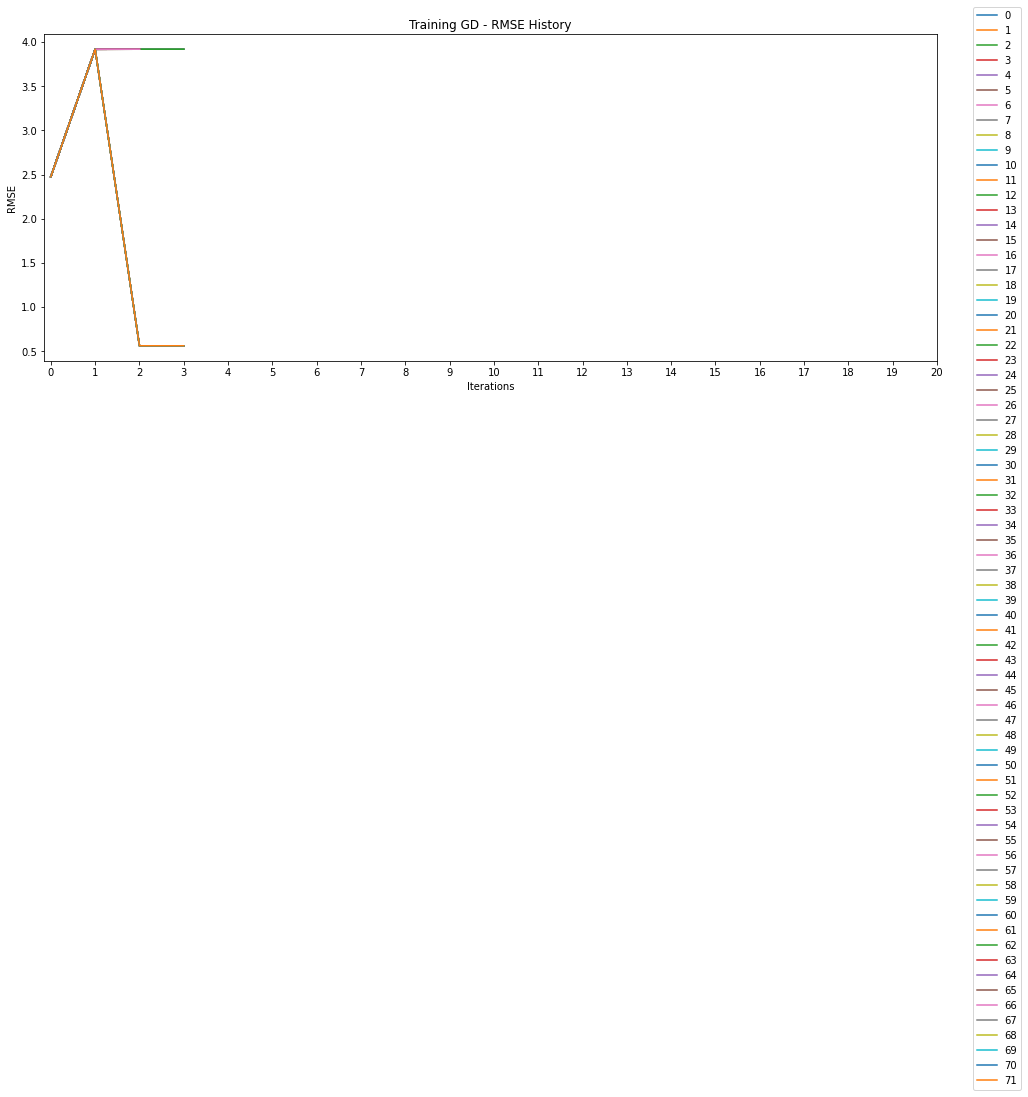

In [ ]:
lines = results.History

plt.figure(figsize=(16,6))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))
plt.legend(lines.index,loc='upper right',bbox_to_anchor=(1.1, 1.1))
plt.title('Training GD - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.show();

**Focus on the top 3:**

In [ ]:
results['RMSEFloat'] = results['RMSE'].astype(float)
nSmallestIdx= results['RMSEFloat'].nsmallest(3).index
results.loc[nSmallestIdx,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,IterPerformed,RMSEFloat
13,5,20,0.01,0.01,0.00100,0.194337,0.0,0.0,0.086368,0.085440,"[2.4775526691710037, 3.9190561172011216, 0.561...",0.317081,4.0,0.194337
14,5,20,0.01,0.10,0.00001,0.194337,0.0,0.0,0.089091,0.084540,"[2.4775335634765314, 3.9190561172011216, 0.561...",0.308070,4.0,0.194337
17,5,20,0.01,1.00,0.00100,0.194337,0.0,0.0,0.087637,0.085232,"[2.4775028636706593, 3.9190561172011216, 0.561...",0.321073,4.0,0.194337


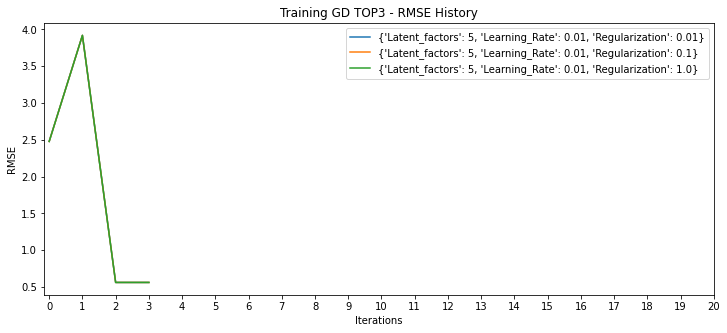

In [ ]:
lines = lines[nSmallestIdx]
plt.figure(figsize=(12,5))

for l in lines:
    plt.plot(l)

plt.xticks(np.arange(n_iterations[0]+1))

leg = (results.loc[nSmallestIdx,['Latent_factors','Learning_Rate','Regularization']]).T.to_dict().values()
plt.xticks(np.arange(n_iterations[0]+1))
plt.title('Training GD TOP3 - RMSE History')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(leg)
plt.show();

In [ ]:
# RMSE is important but we can also use other metrics we can use to evaluate the model
# here we gave RMSE a weight of 10 and all other metrics a weight of 1
results["RMSERank"] = results["RMSEFloat"].rank(method='dense',ascending=False, pct= True) * 10
results["MRR_5Rank"] = results["MRR_5"].rank(method='dense',ascending=True, pct= True)
results["MRR_10Rank"] = results["MRR_10"].rank(method='dense',ascending=True, pct= True)
results["NDCG_5Rank"] = results["NDCG_5"].rank(method='dense',ascending=True, pct= True)
results["NDCG_10Rank"] = results["NDCG_10"].rank(method='dense',ascending=True, pct= True)
results["Rank"] = results[["RMSERank","MRR_5Rank","MRR_10Rank","NDCG_5Rank","NDCG_10Rank"]].mean(axis=1)
results["Method"]= "MF HypParSearch"
results.sort_values(by='Rank',ascending=False).head(3)

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,...,Time,IterPerformed,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
14,5,20,0.01,0.10,0.00001,0.194337,0.0,0.0,0.089091,0.084540,...,0.308070,4.0,0.194337,10.0,0.032258,0.02,1.000000,0.955224,2.401496,MF HypParSearch
17,5,20,0.01,1.00,0.00100,0.194337,0.0,0.0,0.087637,0.085232,...,0.321073,4.0,0.194337,10.0,0.032258,0.02,0.968254,0.985075,2.401117,MF HypParSearch
13,5,20,0.01,0.01,0.00100,0.194337,0.0,0.0,0.086368,0.085440,...,0.317081,4.0,0.194337,10.0,0.032258,0.02,0.952381,1.000000,2.400928,MF HypParSearch



**Q: is there a clear winner?**  

In [ ]:
# The 3 best performing parameters set in RMSE terms showed similar results (+/- 0.5 %) in all evaluation measures
bestIdx= results['Rank'].nlargest(1).index
results.iloc[bestIdx,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,...,Time,IterPerformed,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
14,5,20,0.01,0.1,0.00001,0.194337,0.0,0.0,0.089091,0.08454,...,0.30807,4.0,0.194337,10.0,0.032258,0.02,1.0,0.955224,2.401496,MF HypParSearch


Please add your winner to `final_results` dataframe.

In [ ]:
# final_results = pd.DataFrame(columns=final_results.columns)
final_results= final_results.append(results.loc[bestIdx,['Method','Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time']],ignore_index=True)
final_results
# pass

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence
0,Popularity,0.007002,1.864757,0.056893,0.070393,0.034130,0.038721,NaN,NaN,NaN,NaN,NaN
1,MF,0.320073,0.194337,0.000000,0.000000,0.087655,0.085755,NaN,NaN,NaN,NaN,NaN
2,MF HypParSearch,0.308070,0.194337,0.000000,0.000000,0.089091,0.084540,5,20,0.01,0.1,0.00001


In [ ]:
#  helper function to plot the results
def plotMetric(df, metric):
    plt.figure(figsize=(15,6))
    metricFormatted= metric.replace("_"," ")
    columns = [metric, 'RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10']
    resultsGrouped = df[columns].groupby([metric]).mean()
    plt.suptitle(f'Metrics evaluation per {metricFormatted}',fontsize=16)
    plt.tight_layout(pad=5.0)
    #  draw sub plots of the metrics
    for i,KPI in enumerate(['RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10']):
        plt.subplot(2,3,i+1)
        plt.plot(resultsGrouped.index,resultsGrouped[KPI])
        plt.title(f'{KPI} ')
        plt.xticks(resultsGrouped.index, rotation=45)
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
    plt.show()

# plotMetric(results,'Latent_factors')


**Understanding The Effect - `Latent Factors` - Your Conclusions:**


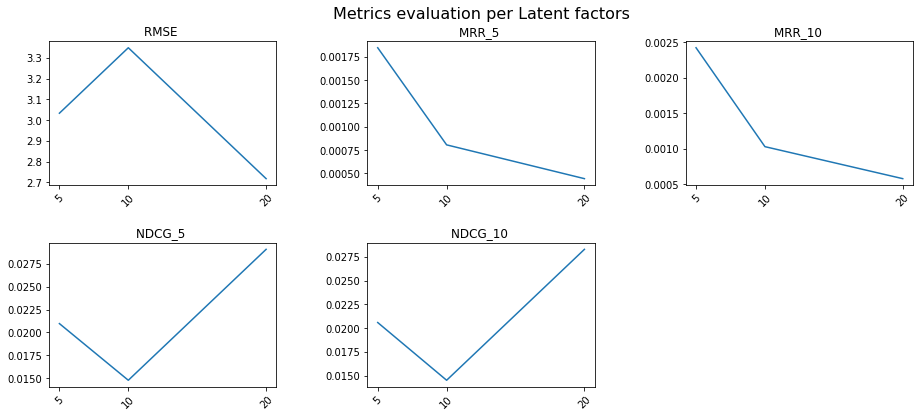

In [ ]:
# for the latent factors variable we can conclud that 10 produce best results across all evaluation metrics ecept for MRR_10.
#  for MRR_10 the best results are produced by 5 latent factors.
#  this insinuates that the information captured within the data is best represented by 10 latent factors, and that the model is overfitting when using 20 latent factors.
plotMetric(results,'Latent_factors')


**Understanding The Effect - `Learning Rate` - Your Conclusions:**


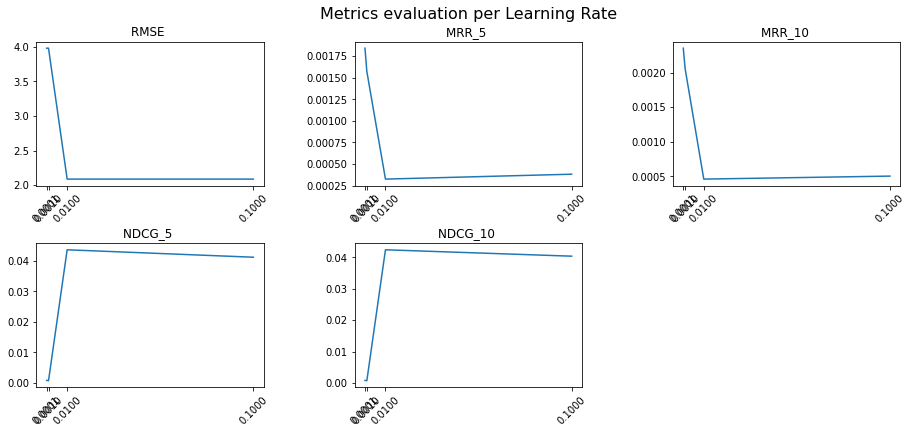

In [ ]:
#  a learning rate of 0.01 seems to produce the best results for RMSE and NDCG. 
#  for MRR_5 and MRR_10 the best results are produced by a learning rate of 0.001.
plotMetric(results,'Learning_Rate')

**Understanding The Effect - `Regularization` - Your Conclusions:**

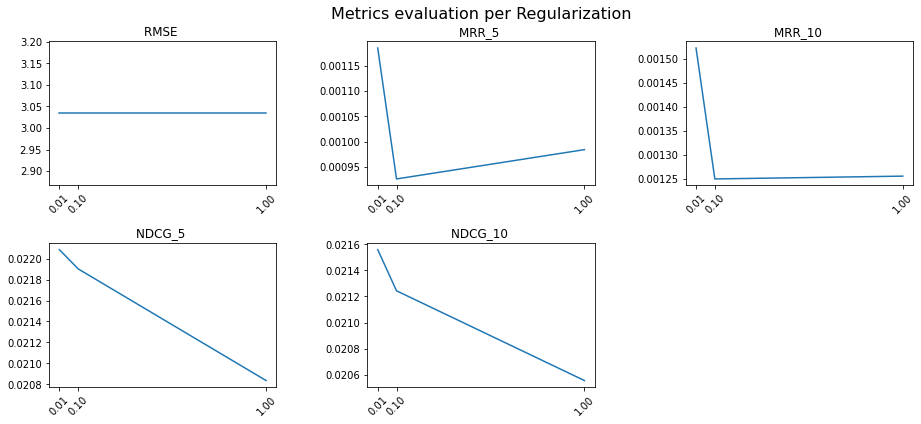

In [ ]:
# both RMSE and NDCG are best when the regularization is set to 0.1.
#  for MRR_5 and MRR_10 the best results are produced by a regularization of 1
plotMetric(results,'Regularization')

<br><br><br>

## D. Bias only based model
#### Repeat the explicit matrix factorization implementation for the bias only model. Please use the same visualizations.  

<br>

**Hyperparams search + train the model :**

In [ ]:
n_iterations   = [20, 100] # just one value due to computational power
convergence    = [1e-5,1e-3]  
latent_factors = [5, 10, 20]
regularization = [0.01, 0.1, 1]
learning_rate  = [0.001, 0.01, 0.1]

results = pd.DataFrame(columns=['Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','History','Time'])

for n_iter in n_iterations:
    for lf in latent_factors:
        for lr in learning_rate:
            for reg in regularization:
                for conv in convergence:

                    dic = {'Iterations':n_iter,'Latent_factors':lf,'Learning_Rate':lr,'Regularization':reg,'Convergence':conv}

                    # initialize model
                    biasOnly = MF(train.values,n_factors=lf, only_bias=True)
                    
                    # record training time
                    start = time.time()
                    
                    # train MF
                    biasOnly.fit(n_iterations=n_iter,verbose=False,learning_rate=lr,regularization=reg,convergence=conv)
                    dic['Time'] = time.time() - start
                    
                    # eval model
                    # please use the model evaluation funcntions 
                    dic["RMSE"]    = biasOnly.get_rmse(test.values)
                    dic["MRR_5"]   = biasOnly.get_mrr(test.values,k=5)
                    dic["MRR_10"]  = biasOnly.get_mrr(test.values,k=10)
                    dic["NDCG_5"]  = biasOnly.get_ndcg(test.values,k=5)
                    dic["NDCG_10"] = biasOnly.get_ndcg(test.values,k=10)
                    
                    # record model history
                    dic['History'] = biasOnly.history # model 
                    
                    # add experiment
                    results = results.append(dic,ignore_index=True)
                    # print('Done with ',dic)

results.head(5)

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time
0,5,20,0.001,0.01,0.00001,3.980053,0.001803,0.002053,0.000558,0.000640,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.183041
1,5,20,0.001,0.01,0.00100,3.980053,0.001803,0.002053,0.000558,0.000640,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175040
2,5,20,0.001,0.10,0.00001,3.980053,0.001750,0.001882,0.000630,0.000610,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175040
3,5,20,0.001,0.10,0.00100,3.980053,0.001750,0.001882,0.000630,0.000610,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175040
4,5,20,0.001,1.00,0.00001,3.980053,0.002103,0.002354,0.000729,0.000735,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.177040


**Choose your top3 models:**


In [ ]:
results['RMSEFloat'] = results['RMSE'].astype(float)
nSmallestIdx= results['RMSEFloat'].nsmallest(3).index
results.loc[nSmallestIdx,:]

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,RMSEFloat
0,5,20,0.001,0.01,0.00001,3.980053,0.001803,0.002053,0.000558,0.00064,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.183041,3.980053
1,5,20,0.001,0.01,0.00100,3.980053,0.001803,0.002053,0.000558,0.00064,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175040,3.980053
2,5,20,0.001,0.10,0.00001,3.980053,0.001750,0.001882,0.000630,0.00061,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175040,3.980053


**Add your winner to `final_resuls` dataframe:**

In [ ]:
# RMSE is important but we can also use other metrics we can use to evaluate the model
# here we gave RMSE a weight of 10 and all other metrics a weight of 1
results["RMSERank"] = results["RMSEFloat"].rank(method='dense',ascending=False, pct= True) * 10
results["MRR_5Rank"] = results["MRR_5"].rank(method='dense',ascending=True, pct= True)
results["MRR_10Rank"] = results["MRR_10"].rank(method='dense',ascending=True, pct= True)
results["NDCG_5Rank"] = results["NDCG_5"].rank(method='dense',ascending=True, pct= True)
results["NDCG_10Rank"] = results["NDCG_10"].rank(method='dense',ascending=True, pct= True)
results["Rank"] = results[["RMSERank","MRR_5Rank","MRR_10Rank","NDCG_5Rank","NDCG_10Rank"]].mean(axis=1)
results["Method"]= "Bias Only HypParSearch"
results.sort_values(by='Rank',ascending=False).head(3)

,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,History,Time,RMSEFloat,RMSERank,MRR_5Rank,MRR_10Rank,NDCG_5Rank,NDCG_10Rank,Rank,Method
22,10,20,0.001,1.0,0.00001,3.980053,0.002103,0.002354,0.000729,0.000735,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.174039,3.980053,10.0,1.0,1.0,1.0,1.0,2.8,Bias Only HypParSearch
77,10,100,0.001,1.0,0.00100,3.980053,0.002103,0.002354,0.000729,0.000735,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.175060,3.980053,10.0,1.0,1.0,1.0,1.0,2.8,Bias Only HypParSearch
23,10,20,0.001,1.0,0.00100,3.980053,0.002103,0.002354,0.000729,0.000735,"[2.4759684491911473, 3.9190561172011216, 3.919...",0.176039,3.980053,10.0,1.0,1.0,1.0,1.0,2.8,Bias Only HypParSearch


In [ ]:
bestIdx= results['Rank'].nlargest(1).index
results.iloc[bestIdx,:]
final_results= final_results.append(results.loc[bestIdx,['Method','Latent_factors','Iterations','Learning_Rate','Regularization','Convergence','RMSE','MRR_5','MRR_10','NDCG_5','NDCG_10','Time']],ignore_index=True)
final_results

,Method,Time,RMSE,MRR_5,MRR_10,NDCG_5,NDCG_10,Latent_factors,Iterations,Learning_Rate,Regularization,Convergence
0,Popularity,0.007002,1.864757,0.056893,0.070393,0.034130,0.038721,NaN,NaN,NaN,NaN,NaN
1,MF,0.320073,0.194337,0.000000,0.000000,0.087655,0.085755,NaN,NaN,NaN,NaN,NaN
2,MF HypParSearch,0.308070,0.194337,0.000000,0.000000,0.089091,0.084540,5,20,0.010,0.1,0.00001
3,Bias Only HypParSearch,0.177040,3.980053,0.002103,0.002354,0.000729,0.000735,5,20,0.001,1.0,0.00001


<br><br>
**Different Methos - Conclude Final Results**

In [ ]:
final_results = final_results.set_index('Method')
final_results['Time_Ratio'] = final_results['Time_Ratio']/final_results['Time_Ratio'].max()

final_results.T.plot(kind="bar", figsize=(15,6))
plt.title("Results of all Methods", fontsize=20)
plt.xlabel("Evaluation Methods", fontsize=16)
plt.ylabel("Evaluation Values", fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.show();

final_results

KeyError: 'Time_Ratio'

**Understand `only-Bias-model` VS `full-model` - Your Conclusions:**  
- 
-
-




<br><br><br><br><br><br><br>

## E. Discussion 

Describe your challenges and findings, including comparison between the algorithms as well as your recommendations for how to select the latent factor dimension, the contribution of regularization and pros\cons of the different algorithms.

In your comparison refer to the evaluation metrics, training and inference duration, learning convergence and additional aspects you find relevant.

`popularity bias:` Please refers to system recommends the movies with the most interactions without any personalization

`item cold-start problem:` Please refers to when movies added to the catalogue have either none or very little interactions while recommender rely on the movie’s interactions to make recommendations

`scalability issue:` Please refers to lack of the ability to scale to much larger sets of data when more and more users and movies added into our database

<< Your Answer here >> 

`MRR VS nDCG`

**MRR**  
`Pros:`   
    -   
    -   

`Cons:`    
    -   
    -   

**NDCG**  
`Pros:`  
    -   
    -   

`Cons:`  
    -   
    -   

<br><br><br><br>

# Question 4: 


## Item similarity & explainability 
a)	Suggest a method to find similarity between items. Demonstrate the approach on a set of 5 item pairs of your choice based on item representation by your best matrix factorization model. Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach. 

b)	Select two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model. Demonstrate your estimation, using few items from the dataset and the items side information available in the dataset and\or external information. 


**Find similarity between items and demonstrate the approach on a set of 3 item triplets of your choice based on item representation by your one of your top3 matrix factorization model.**
  
**Leverage the items side information available in the dataset to demonstrate the effectiveness of the suggested approach.**

In [ ]:
model = None
model.fit()

: 

**Known methods to find similarity between items are:**
- Pearson Corellation  
- Cosine Similarity 
- Mean Difference
- L2 Distance

**Please implement them using numpy package:** 
(for example: np.linalg)


In [ ]:
def get_item2vec(mf,i):
    pass


def get_pearson_similarity(a,b):
    pass


def get_cosine_similarity(a,b):
    pass


def get_mean_diff_similarity(a1,a2):
    pass


def get_l2_similarity(a1,a2):
    pass


: 

**For the next step, please choose your favorite method.**  

**Please compare 3 triplets of movies, and for each triplet create this:**   
Create a dataframe same as the example

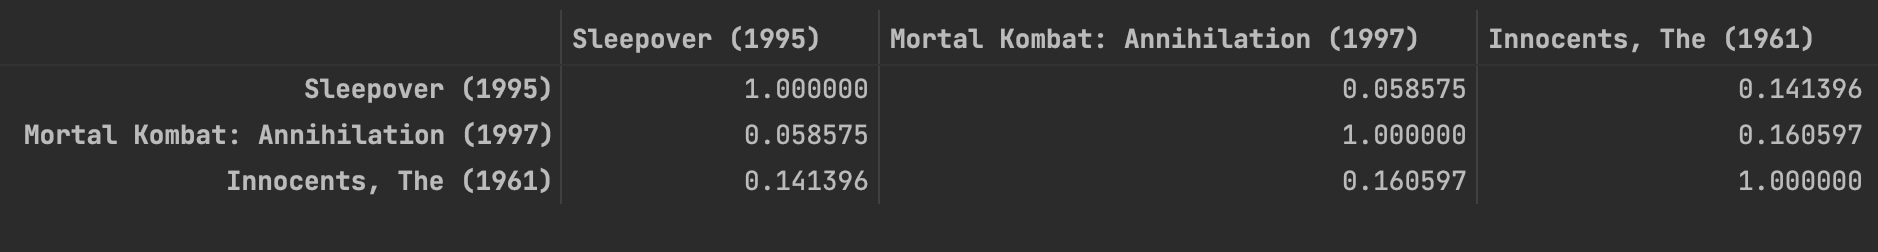

**First Triplet:**

: 

**Second Triplet:**

: 

**Third Triplet**

: 

<br><br><br>
**Find two latent dimensions of your matrix factorization model and try to estimate the latent ‘meaning’ of the learnt matrix factorization model.**

**Tip:**  
would we get a good seperation for different genres?  
For example, here we can see that this is not a good seperation.




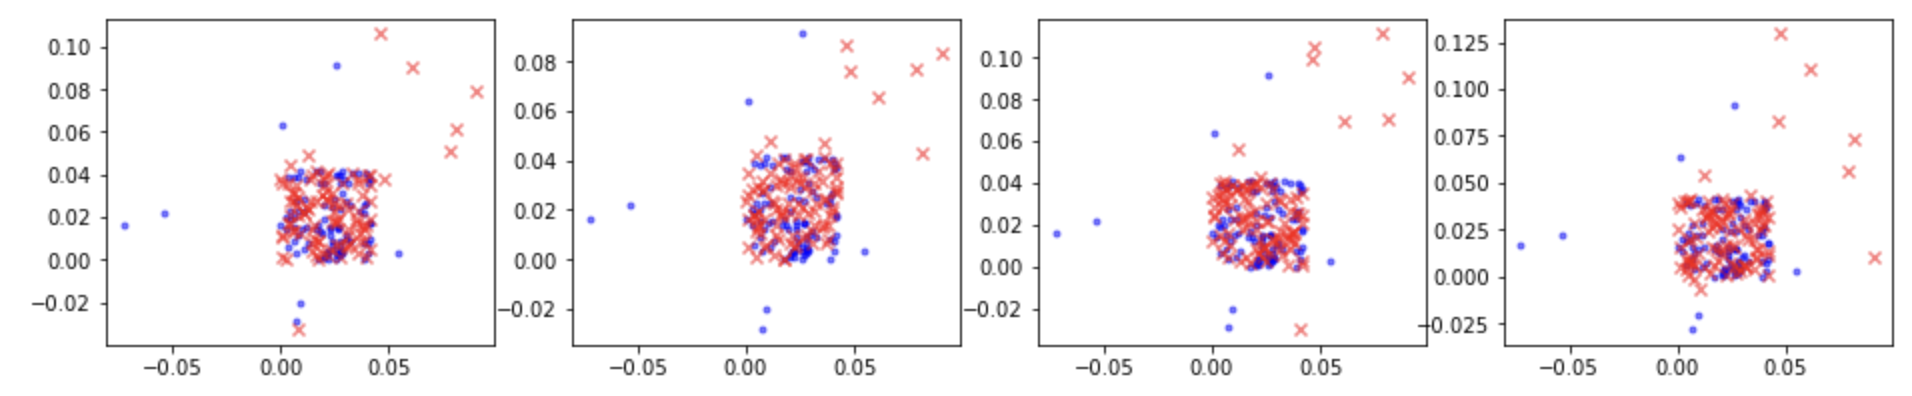

: 